# Bayesian computations with Neural Networks

Neural network training is typically done with maximum likelihood estimation. Given the number of parameter invariances in neural network architectures, this often introduces a large number of local minima, making global optimisation very difficult.

JAXNS can easily compute the evidence and posterior of a neural network. The larger number of parameters means that we should be careful with how accurate we want this to be. With high precision, we'll need more likelihood evaluations

In [1]:
import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"

try:
    import haiku as hk
except ImportError:
    print("You must `pip install dm-haiku` first.")
    raise

from itertools import product

import jax
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap
from jax.flatten_util import ravel_pytree

from jaxns import resample

tfpd = tfp.distributions





INFO[2023-12-11 12:56:49,503]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 12:56:49,504]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 12:56:49,505]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-11 12:56:49,505]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# Generate data

def xor_reduce(x):
    """
    Computes the XOR reduction on a sequence of bits.

    Examples:
        100 -> xor(xor(1,0),0) = 1
        001 -> xor(xor(0,0),1) = 1
        110 -> xor(xor(1,1),0) = 0
        011 -> xor(xor(0,1),1) = 0

    Args:
        x: boolean vector of bits.

    Returns:
        bool, scalar
    """
    output = x[0]
    for i in range(1, x.shape[-1]):
        output = jnp.logical_xor(output, x[i])
    return output


num_variables = 7
options = [True, False]
x = jnp.asarray(list(product(options, repeat=num_variables)))  #N,2
y = vmap(xor_reduce)(x)[:, None]  #N, 1
x = x.astype(jnp.float32)
print("Data:")

for input, output in zip(x, y):
    print(f"{input} -> {output}")


Data:
[1. 1. 1. 1. 1. 1. 1.] -> [ True]
[1. 1. 1. 1. 1. 1. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 1.] -> [False]
[1. 1. 1. 1. 1. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 1. 1.] -> [False]
[1. 1. 1. 1. 0. 1. 0.] -> [ True]
[1. 1. 1. 1. 0. 0. 1.] -> [ True]
[1. 1. 1. 1. 0. 0. 0.] -> [False]
[1. 1. 1. 0. 1. 1. 1.] -> [False]
[1. 1. 1. 0. 1. 1. 0.] -> [ True]
[1. 1. 1. 0. 1. 0. 1.] -> [ True]
[1. 1. 1. 0. 1. 0. 0.] -> [False]
[1. 1. 1. 0. 0. 1. 1.] -> [ True]
[1. 1. 1. 0. 0. 1. 0.] -> [False]
[1. 1. 1. 0. 0. 0. 1.] -> [False]
[1. 1. 1. 0. 0. 0. 0.] -> [ True]
[1. 1. 0. 1. 1. 1. 1.] -> [False]
[1. 1. 0. 1. 1. 1. 0.] -> [ True]
[1. 1. 0. 1. 1. 0. 1.] -> [ True]
[1. 1. 0. 1. 1. 0. 0.] -> [False]
[1. 1. 0. 1. 0. 1. 1.] -> [ True]
[1. 1. 0. 1. 0. 1. 0.] -> [False]
[1. 1. 0. 1. 0. 0. 1.] -> [False]
[1. 1. 0. 1. 0. 0. 0.] -> [ True]
[1. 1. 0. 0. 1. 1. 1.] -> [ True]
[1. 1. 0. 0. 1. 1. 0.] -> [False]
[1. 1. 0. 0. 1. 0. 1.] -> [False]
[1. 1. 0. 0. 1. 0. 0.] -> [ True]
[1. 1. 0. 0. 0. 1. 1.] -> [False]
[1. 1. 0

In [3]:
from jaxns.internals.types import float_type
from jax._src.nn.functions import softplus


# Define the likelihood, using Haiku as our framework for neural networks

def nn_model(x, is_training=False):
    mlp = hk.Sequential([hk.Linear(4),
                         jax.nn.sigmoid,
                         hk.Linear(1)])
    return mlp(x)


nn_model = hk.without_apply_rng(hk.transform(nn_model))
# We must call the model once to get the params shape and type as a big pytree
# We then use ravel_pytree to flatten and get the unflatten function.
init_params = nn_model.init(random.PRNGKey(2345), x)
init_params_flat, unravel_func = ravel_pytree(init_params)
n_dims = init_params_flat.size
print("Number of parameters:", n_dims)


def log_likelihood(params):
    """
    log(P(y|p))
    p = exp(logits)/1 - exp(logits)
    = log(p) * y + log(1-p) * (1-y)
    = logits * y1 - log(exp(-logits)/(exp(-logits) - 1)) * y0
    """
    params_dict = unravel_func(params)
    logits = nn_model.apply(params_dict, x)
    log_prob0, log_prob1 = -softplus(logits), -softplus(-logits)
    #log(p) * y + log(1-p) * (1-y)
    log_prob = jnp.mean(jnp.where(y, log_prob1, log_prob0))
    return jnp.asarray(log_prob, float_type)


Number of parameters: 37


In [4]:
from jaxns import Prior, Model


# Build the model

def prior_model():
    params = yield Prior(tfpd.Uniform(-10 * jnp.ones(n_dims), 10. * jnp.ones(n_dims)), name='params')

    return params


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)


INFO[2023-12-11 12:56:51,457]: Sanity check...
INFO[2023-12-11 12:56:51,953]: Sanity check passed


In [5]:

from jaxns import DefaultNestedSampler

# Create the nested sampler class. In this case without any tuning.
ns = DefaultNestedSampler(model=model, max_samples=1e6,
                          num_parallel_workers=1)#len(jax.devices()))

ns_compiled = jax.jit(ns).lower(random.PRNGKey(0)).compile()

termination_reason, state = ns_compiled(random.PRNGKey(42))
results = ns.to_results(termination_reason=termination_reason, state=state)


/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 49625
samples: 12276
phantom samples: 11160.0
likelihood evals / sample: 4.0
phantom fraction (%): 90.9%
--------
logZ=-2.562 +- 0.073
H=2.7
ESS=245.72225952148438
--------
params[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
params[0]: -0.5 +- 5.5 | -8.1 / -0.4 / 7.5 | 7.7 | 7.7
params[1]: -0.1 +- 5.9 | -8.1 / -0.2 / 8.0 | -5.8 | -5.8
params[2]: -0.1 +- 5.9 | -8.3 / -0.4 / 8.1 | -0.5 | -0.5
params[3]: 1.0 +- 5.9 | -8.1 / 2.0 / 8.5 | 4.7 | 4.7
params[4]: 0.3 +- 5.9 | -8.1 / 0.9 / 7.9 | 8.9 | 8.9
params[5]: -0.2 +- 5.7 | -8.0 / -0.4 / 7.9 | -9.5 | -9.5
params[6]: 0.4 +- 5.6 | -8.1 / 0.4 / 7.9 | 0.8 | 0.8
params[7]: -0.6 +- 6.1 | -8.9 / -0.8 / 7.9 | -5.7 | -5.7
params[8]: 0.3 +- 6.1 | -8.4 / 0.0 / 8.4 | 9.9 | 9.9
params[9]: -0.1 +- 5.5 | -7.8 / -0.1 / 7.5 | 9.7 | 9.7
params[10]: -0.3 +- 6.0 | -8.1 / -0.6 / 8.1 | -7.0 | -7.0
params[11]: 0.1 +- 5.8 | -7.9 / 1.0 / 7.8 | -7.3 | -7.

WARNING[2023-12-11 12:57:08,836]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


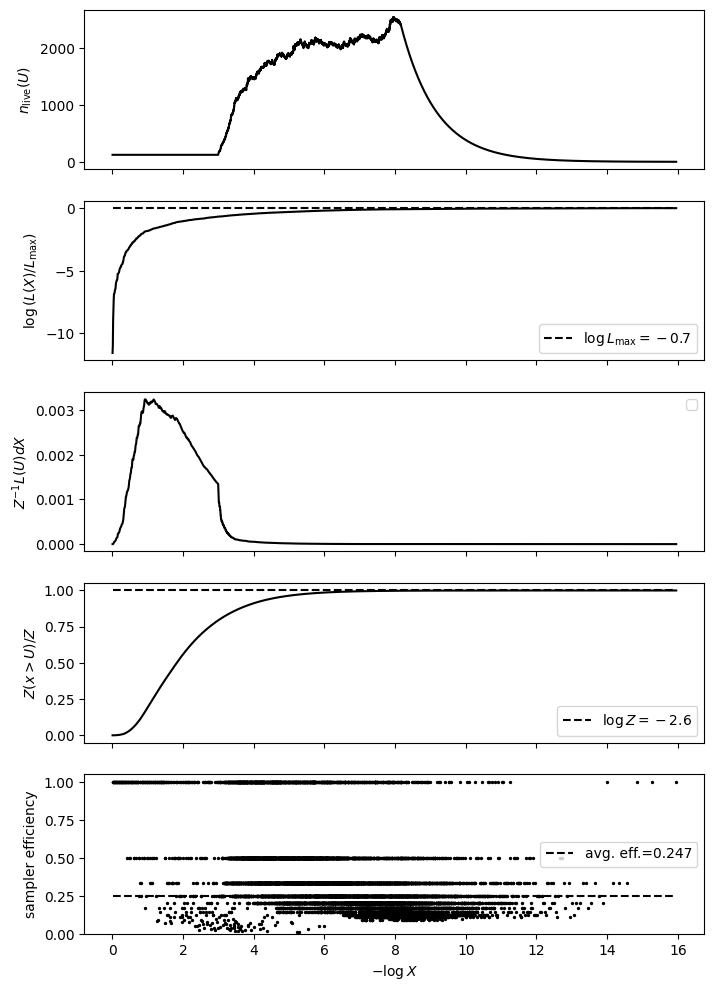

In [6]:
ns.summary(results)
ns.plot_diagnostics(results)

In [7]:
samples = resample(random.PRNGKey(45), results.samples, results.log_dp_mean, S=int(results.ESS), replace=True)


def predict(params):
    params_dict = unravel_func(params)
    logits = nn_model.apply(params_dict, x)
    return jax.nn.sigmoid(logits)[:, 0]


predictions = vmap(predict)(samples['params'])

for i in range(len(y)):
    print(f"{i}: {x[i]} -> {y[i]} | pred: {jnp.percentile(predictions[:, i], jnp.asarray([5, 50, 95]))}")

0: [1. 1. 1. 1. 1. 1. 1.] -> [ True] | pred: [0.00190839 0.55767906 0.99929374]
1: [1. 1. 1. 1. 1. 1. 0.] -> [False] | pred: [0.00150659 0.5712224  0.99879754]
2: [1. 1. 1. 1. 1. 0. 1.] -> [False] | pred: [0.00132005 0.6107066  0.9993961 ]
3: [1. 1. 1. 1. 1. 0. 0.] -> [ True] | pred: [0.00137255 0.5512024  0.9994669 ]
4: [1. 1. 1. 1. 0. 1. 1.] -> [False] | pred: [0.00164889 0.4489799  0.99709225]
5: [1. 1. 1. 1. 0. 1. 0.] -> [ True] | pred: [0.0012055  0.41566262 0.9975157 ]
6: [1. 1. 1. 1. 0. 0. 1.] -> [ True] | pred: [0.00164253 0.49959704 0.9989596 ]
7: [1. 1. 1. 1. 0. 0. 0.] -> [False] | pred: [9.407826e-04 5.701306e-01 9.991980e-01]
8: [1. 1. 1. 0. 1. 1. 1.] -> [False] | pred: [0.00142991 0.6152784  0.999125  ]
9: [1. 1. 1. 0. 1. 1. 0.] -> [ True] | pred: [0.00137347 0.524491   0.9994437 ]
10: [1. 1. 1. 0. 1. 0. 1.] -> [ True] | pred: [9.1889675e-04 5.3139204e-01 9.9951994e-01]
11: [1. 1. 1. 0. 1. 0. 0.] -> [False] | pred: [0.00134089 0.53135777 0.99969006]
12: [1. 1. 1. 0. 0. 1. 

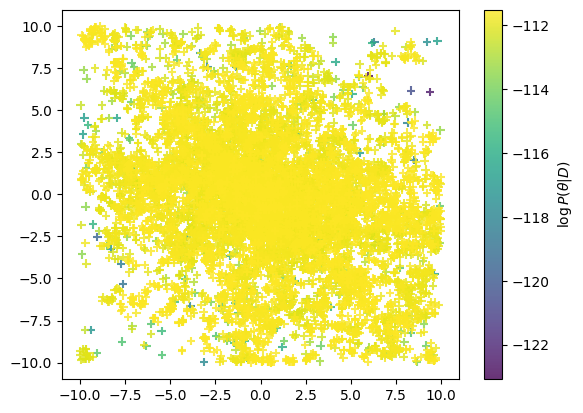

In [8]:

sc = plt.scatter(*results.samples['params'][:, -5:-3].T, marker='+', alpha=0.8, c=results.log_posterior_density)
plt.colorbar(sc, label=r'$\log P(\theta | D)$')
plt.show()

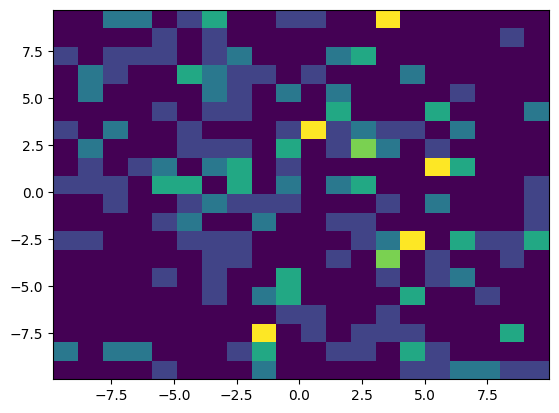

In [9]:
plt.hist2d(*samples['params'][:, -5:-3].T, bins=20)
plt.show()